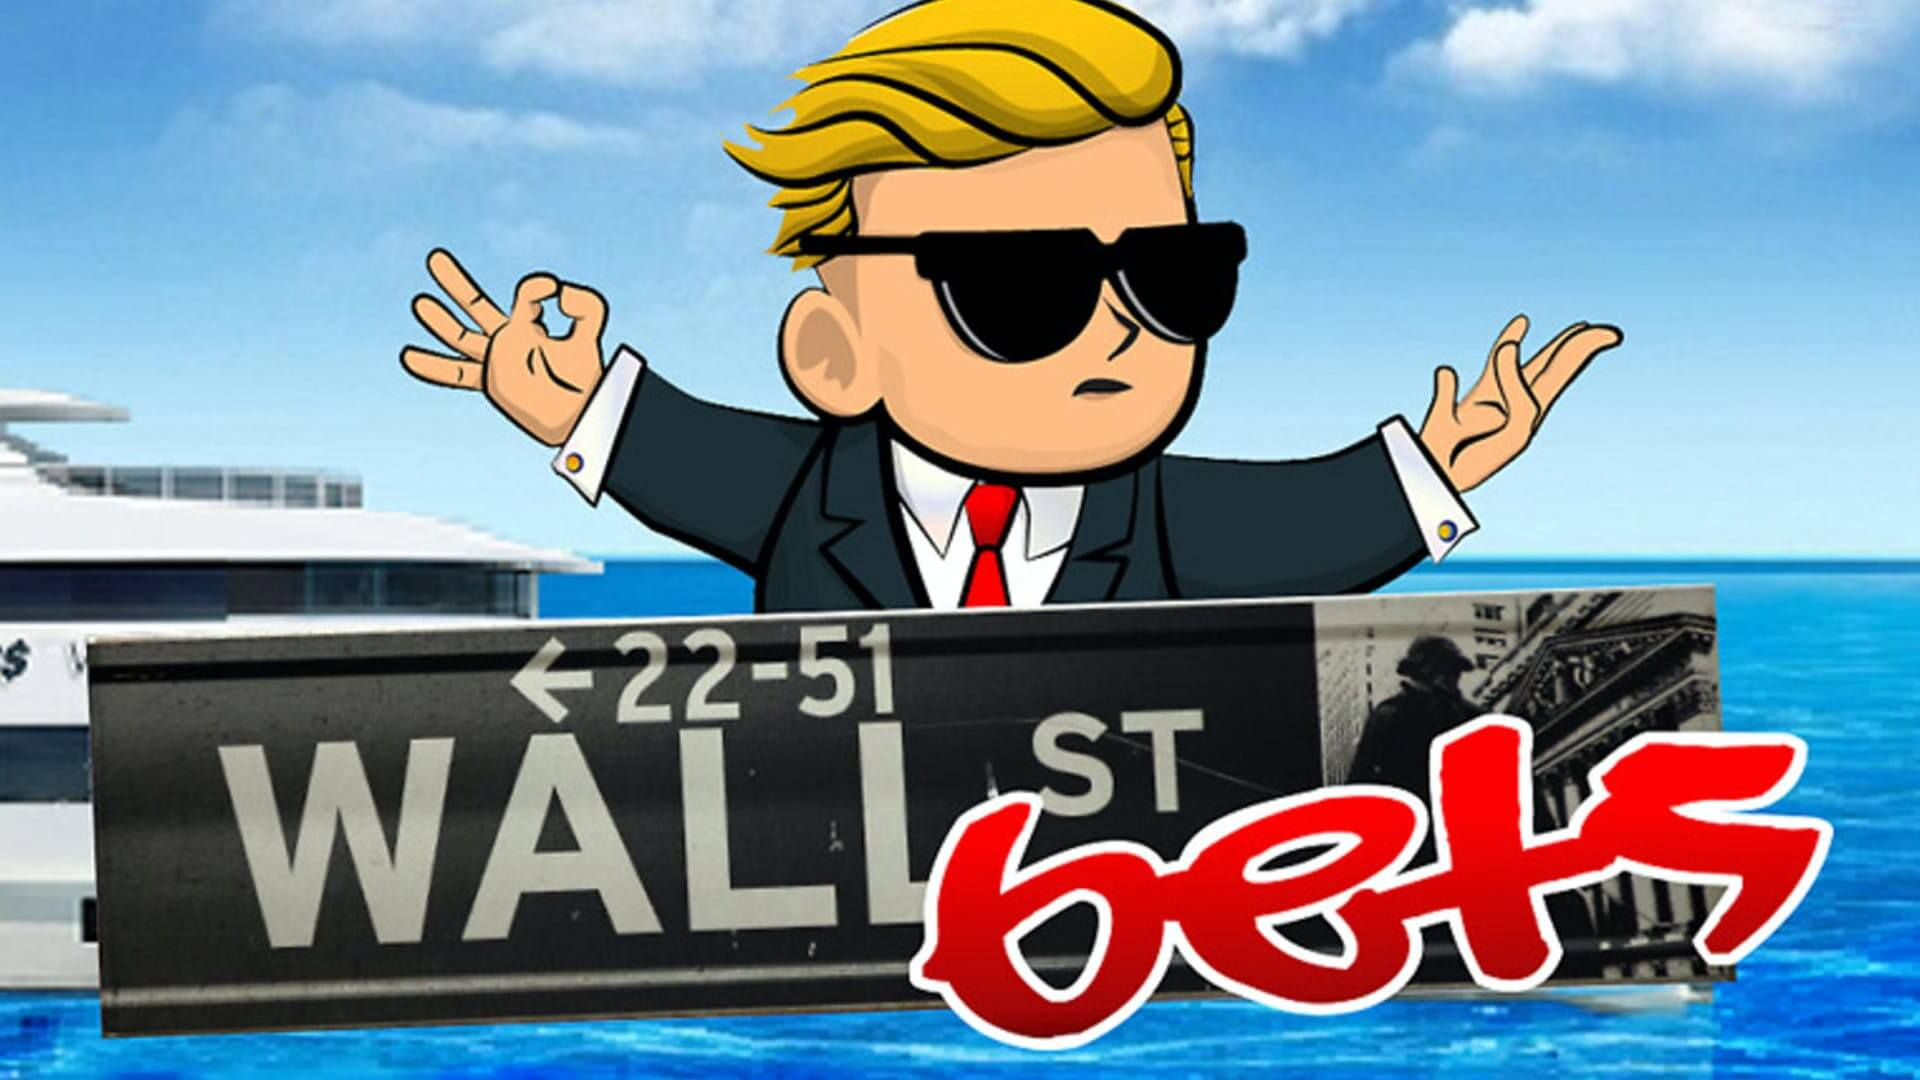

# Reddit Sentiment Analysis

By Doug Mill
<br>
github.com/cyborgsage

## Overview

Interest in the stock market has grown in the past few years, with COVID seemingly fueling some of the risk on behavior within markets. Last year, this increased interest crossed over into many other facets of our lives. With the convergence of reddit, social media, memes, the stock market, and mainstream media, the famed GameStop and AMC short squeezes captivated financial audiences in late January of this year. Through data science and research, we can take these newfound information sources and use them to benefit the broader retail trading audience.

## Business Understanding

I am representing an independent asset management and research firm that was contacted by an international pension and sovereign wealth fund. Previously, they had only been subscribed to traditional market news. When the GME and AMC squeezes broke the news, the fund took notice. They have asked me to publish research about whether the wallstreetbets subreddit is worth mining as an information source and inquired about diversifying into meme stocks. My goal here is to fulfill their needs efficiently and practically. I took a two-pronged approach to NLP; training classification models with a manually labeled sample as my target, and using NLP to find the top mentioned tickers on r/wsb.

## Data Understanding

The data that was used for this project was exclusively scraped from the wallstreetbets subreddit of the social media platform Reddit. A subreddit is a subgroup of the platform dedicated to their own shared interest. In the case of wallstreetbets, that happens to be trading. When I first joined the group in 2019, directional single leg options were almost exclusively promoted. Shares were frowned upon. With the humungous movements in stocks such as GME and AMC, things changed in the subreddit forever. The popularity of the board skyrocketed, reaching mainstream appeal, and people were seeing huge gains in shares. What made these companies unique was that AMC was a company on the verge of bankruptcy. Gamestop was an outdated brick and mortar video game retailer. How did these companies explode? The answer lies partially in shorts, gamma squeezing, and the wallstreetbets subreddit. In order to investigate, I scraped 100k comments containing the keyword "AMC" and 100k comments containing the keyword "GME" from wallstreetbets. The comments were posted between 1/1/21 and 11/20/21, when the project commenced. I used the PushShift API which does a great job with collected big amounts of data relative to the Reddit API.

## Data Preparation

For data preparation, I took my files straight from the API and then cleaned them out. I kept 6 relevant columns out of 40. These columns included "body" (actual comment), "score" (peer feedback), "total awards received" (peer feedback), "created utc" (date-time), "author", and "permalink" (kept these to verify legitimacy of comments). After cleaning out the irrelevant data, I cleaned the comments themselves. I then applied the default VADER for my time series data. This gave me positive, neutral, negative, and compound scores for each comment. I shipped these dataframes off to csvs. For the classification datasets known as "amc_modeling" and "gme_modeling", I tuned VADER by updating the lexicon with some new words and values. My full EDA can be found for both AMC and GME in the appendix folder. <br><br>
After doing this, I realized that I had to establish a ground truth target column. The only way to do this was to manually label the comments myself. I manually labeled 1000 comments each for AMC and GME data. After this, I compared my results to VADER and began to train my own machine learning models on my labels. The positive=bullish, neutral=neutral/can't tell/can't understand, negative=bearish. I am able to detect some degree on sarcasm since I'm reading the comments myself. Also I can access full thread context and can click on links. I also already understand what happened in a historical context fundamentally and from a price standpoint.

In [370]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
import math
from datetime import datetime
import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
from xgboost import XGBClassifier
pd.set_option('display.max_colwidth', -1)

<ipython-input-370-65afdf22ca56>:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
amc_raw = pd.read_csv('data/amc_comments.csv', low_memory=False)

In [3]:
relevant_columns=['body','score','total_awards_received','created_utc','author','permalink']
amc_raw = amc_raw[relevant_columns]

In [4]:
gme_raw = pd.read_csv('data/gme_comments.csv', low_memory=False)
gme_raw = gme_raw[relevant_columns]

### VADER analyzer

In [5]:
stopwords_list = stopwords.words('english')

In [6]:
def new_cleaner(comment):
    punctuation = set(string.punctuation)
    x = comment
    x = re.sub(r'@[\w]*', '', x) #remove @ mentions
    x = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', x) #remove URLs and links
    x = ''.join(ch for ch in x if ch not in punctuation) #remove punctuation
    x = x.replace("[^a-zA-z]", " ") #remove special chars
    x = [word.lower() for word in x.split() if word.lower() not in stopwords_list] #lowercase
    return ' '.join(x)

In [7]:
new_words = {
    'citron': -4.0,'hindenburg': -4.0,'moon': 4.0,'highs': 2.0,'mooning': 4.0,'long': 2.0,'short': -2.0,'call': 4.0,
    'calls': 4.0,'put': -4.0,'puts': -4.0,'breakout': 2.0,'tendie': 2.0,'tendies': 2.0,'town': 2.0,'overvalued': -3.0,
    'undervalued': 3.0,'buy': 4.0,'sell': -4.0,'gone': -1.0,'gtfo': -1.7,'paper': -1.7,'bullish': 4.0,'bearish': -4.0,
    'bagholder': -1.7,'stonk': 1.9,'green': 4.0,'money': 1.2,'print': 2.2,'rocket': 4.0,'bull': 4.0,'bear': -4.0,
    'pumping': 2.5,'sus': -3.0,'offering': -2.3,'rip': -4.0,'downgrade': -3.0,'upgrade': 3.0,'maintain': 1.0,'pump': 1.9,
    'hot': 1.5,'drop': -2.5,'rebound': 1.5,'crack': 2.5,'gang': 2.0,'scam': -2.0,'chamath': -2.0,'snake': -2.0,
    'squeeze': 3.0,'bag': -4.0,'fly': 2.0,'way': 2.0,'high': 2.0,'volume': 2.5,'low': -2.0,'trending': 3.0,'upwards': 3.0,
    'prediction': 1.0,'cult': -1.0,'big': 2.0}

In [139]:
new_vader = SentimentIntensityAnalyzer()
# new_vader.lexicon.update(new_words)

In [140]:
def find_sentiment(post):
    if new_vader.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif new_vader.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

In [10]:
amc_raw['cleaned_body'] = amc_raw['body'].map(lambda x: new_cleaner(x))
amc_raw['new_sentiment'] = amc_raw['cleaned_body'].apply(lambda x: find_sentiment(x))

In [11]:
gme_raw['cleaned_body'] = gme_raw['body'].map(lambda x: new_cleaner(x))
gme_raw['body_sentiment'] = gme_raw['cleaned_body'].apply(lambda x: find_sentiment(x))

In [12]:
# amc_raw.to_csv('data/amc_modeling.csv', index=False)
# gme_raw.to_csv('data/gme_modeling.csv', index=False)

The preprocessing for VADER included converting comments to lowercase, removing "@" mentions between users, removing links, removing stopwords, and vectorizing. I also tested VADER without any preprocessing and it performed the same against my manually labeled data.

In [247]:
amc = pd.read_csv('data/amc_modeling.csv', low_memory=False)
amc.dropna(inplace=True)

In [248]:
gme = pd.read_csv('data/gme_modeling.csv', low_memory=False)
gme.dropna(inplace=True)

### Manually label 1000 comments for AMC.

RULES: AMC Sentiment Only. Sentiments on other things such as other stocks, forum rules, other users, trading styles, etc. disregarded. Bullish=Positive, Neutral=Neutral, Bearish=Negative.
Ex: When the person was excited about making money on shorts, it was still negative. Someone complaining about forum/audience is neutral about the stock. An issue I realized is that it is hard to detect sarcasm and sentiment in many cases without context.

In [249]:
labeled_amc = amc.sample(n=1000, random_state=42)

In [250]:
# labeled_amc.iloc[980:1000]['body']

In [252]:
labels = ['Positive','Positive','Neutral','Positive','Positive','Positive','Neutral','Positive','Neutral','Neutral',
          'Negative','Positive','Neutral','Positive','Neutral','Neutral','Positive','Positive','Neutral','Neutral',
         'Neutral','Negative','Positive','Neutral','Negative','Positive','Positive','Positive','Positive','Positive',
         'Positive','Neutral','Negative','Positive','Positive','Positive','Neutral','Positive','Positive','Positive',
         'Neutral','Neutral','Positive','Negative','Positive','Positive','Neutral','Neutral','Neutral','Negative',
         'Neutral','Negative','Positive','Negative','Positive','Negative','Positive','Positive','Positive','Positive',
         'Neutral','Positive','Neutral','Neutral','Positive','Neutral','Positive','Positive','Negative','Negative',
         'Neutral','Neutral','Neutral','Negative','Neutral','Neutral','Positive','Positive','Neutral','Positive',
         'Positive','Neutral','Positive','Negative','Neutral','Positive','Neutral','Positive','Neutral','Positive',
         'Neutral','Neutral','Neutral','Negative','Neutral','Neutral','Negative','Negative','Neutral','Neutral',
         'Positive','Neutral','Positive','Positive','Neutral','Neutral','Positive','Positive','Positive','Neutral',
         'Neutral','Neutral','Positive','Positive','Positive','Negative','Positive','Positive','Positive','Neutral',
         'Negative','Positive','Neutral','Positive','Positive','Negative','Neutral','Negative','Positive','Positive',
         'Positive','Negative','Negative','Positive','Neutral','Negative','Neutral','Negative','Neutral','Negative',
         'Neutral','Negative','Neutral','Positive','Neutral','Neutral','Neutral','Neutral','Neutral','Negative',
         'Neutral','Positive','Neutral','Positive','Positive','Positive','Neutral','Neutral','Neutral','Positive',
         'Neutral','Neutral','Negative','Positive','Positive','Negative','Neutral','Positive','Negative','Positive',
         'Negative','Positive','Neutral','Neutral','Neutral','Positive','Neutral','Neutral','Positive','Positive',
         'Positive','Neutral','Positive','Negative','Neutral','Neutral','Positive','Neutral','Positive','Negative',
         'Neutral','Positive','Neutral','Positive','Neutral','Positive','Neutral','Neutral','Positive','Positive',
          #200
         'Positive','Positive','Neutral','Neutral','Neutral','Positive','Neutral','Neutral','Neutral','Neutral',
         'Positive','Positive','Neutral','Neutral','Positive','Neutral','Neutral','Neutral','Neutral','Neutral',
         'Neutral','Negative','Neutral','Positive','Positive','Positive','Neutral','Neutral','Neutral','Neutral',
         'Negative','Positive','Negative','Positive','Neutral','Positive','Negative','Positive','Positive','Positive',
         'Neutral','Positive','Positive','Positive','Negative','Positive','Negative','Neutral','Positive','Positive',
         'Neutral','Positive','Negative','Positive','Positive','Neutral','Positive','Positive','Positive','Neutral',
         'Neutral','Positive','Positive','Positive','Positive','Positive','Neutral','Negative','Neutral','Neutral',
         'Neutral','Positive','Positive','Positive','Positive','Negative','Positive','Positive','Neutral','Neutral',
         'Neutral','Positive','Negative','Neutral','Positive','Neutral','Positive','Positive','Neutral','Neutral',
         'Neutral','Positive','Neutral','Positive','Positive','Positive','Neutral','Neutral','Neutral','Neutral',
         'Positive','Negative','Neutral','Positive','Negative','Neutral','Neutral','Positive','Positive','Positive',
         'Positive','Positive','Neutral','Positive','Neutral','Positive','Negative','Neutral','Negative','Positive',
         'Positive','Positive','Neutral','Positive','Negative','Positive','Neutral','Neutral','Positive','Positive',
         'Neutral','Positive','Negative','Positive','Neutral','Neutral','Positive','Positive','Negative','Negative',
         'Positive','Negative','Positive','Neutral','Positive','Positive','Positive','Positive','Positive','Positive',
         'Positive','Negative','Positive','Negative','Positive','Neutral','Positive','Positive','Positive','Positive',
         'Negative','Negative','Neutral','Positive','Positive','Positive','Neutral','Positive','Positive','Positive',
         'Neutral','Neutral','Neutral','Neutral','Neutral','Negative','Positive','Positive','Positive','Neutral',
         'Negative','Negative','Neutral','Positive','Positive','Positive','Neutral','Neutral','Positive','Neutral',
         'Positive','Negative','Positive','Positive','Negative','Negative','Neutral','Neutral','Positive','Negative',
          #400
         'Negative','Positive','Neutral','Positive','Neutral','Negative','Neutral','Negative','Negative','Neutral',
         'Negative','Positive','Positive','Positive','Positive','Positive','Positive','Positive','Positive','Negative',
         'Positive','Positive','Negative','Positive','Neutral','Positive','Neutral','Neutral','Positive','Neutral',
         'Positive','Neutral','Positive','Positive','Negative','Neutral','Negative','Negative','Neutral','Positive',
         'Negative','Negative','Positive','Negative','Negative','Neutral','Neutral','Positive','Positive','Positive',
         'Negative','Negative','Positive','Positive','Negative','Positive','Negative','Negative','Positive','Positive',
         'Neutral','Positive','Negative','Positive','Negative','Positive','Neutral','Positive','Positive','Neutral',
         'Positive','Positive','Neutral','Negative','Positive','Positive','Neutral','Positive','Positive','Positive',
         'Positive','Negative','Negative','Neutral','Positive','Positive','Negative','Positive','Positive','Neutral',
         'Positive','Neutral','Neutral','Positive','Negative','Positive','Negative','Positive','Positive','Negative',
         'Positive','Positive','Positive','Positive','Neutral','Neutral','Negative','Positive','Negative','Positive',
         'Positive','Neutral','Neutral','Positive','Positive','Positive','Positive','Positive','Neutral','Positive',
         'Neutral','Positive','Neutral','Positive','Positive','Positive','Positive','Positive','Positive','Positive',
         'Neutral','Negative','Negative','Neutral','Positive','Negative','Neutral','Negative','Positive','Positive',
         'Neutral','Neutral','Positive','Negative','Neutral','Neutral','Positive','Positive','Positive','Negative',
         'Positive','Negative','Neutral','Positive','Neutral','Negative','Negative','Positive','Positive','Negative',
         'Positive','Neutral','Positive','Positive','Positive','Positive','Negative','Neutral','Positive','Neutral',
         'Neutral','Negative','Positive','Positive','Positive','Positive','Neutral','Negative','Negative','Negative',
         'Negative','Positive','Negative','Positive','Positive','Neutral','Neutral','Neutral','Positive','Positive',
         'Positive','Neutral','Positive','Neutral','Positive','Neutral','Positive','Positive','Positive','Negative',
          #600
         'Negative','Negative','Positive','Positive','Neutral','Positive','Neutral','Neutral','Neutral','Positive',
         'Positive','Neutral','Positive','Negative','Positive','Positive','Positive','Neutral','Negative','Neutral',
         'Positive','Positive','Positive','Positive','Positive','Negative','Positive','Negative','Positive','Negative',
         'Negative','Positive','Positive','Neutral','Neutral','Neutral','Negative','Positive','Negative','Negative',
         'Positive','Positive','Neutral','Positive','Positive','Neutral','Positive','Positive','Neutral','Negative',
         'Neutral','Negative','Neutral','Neutral','Neutral','Positive','Positive','Negative','Neutral','Positive',
         'Neutral','Positive','Neutral','Negative','Positive','Positive','Positive','Neutral','Positive','Neutral',
         'Neutral','Negative','Positive','Positive','Negative','Neutral','Positive','Positive','Positive','Neutral',
         'Negative','Negative','Negative','Positive','Neutral','Neutral','Positive','Neutral','Positive','Neutral',
         'Positive','Negative','Positive','Negative','Neutral','Positive','Negative','Negative','Positive','Neutral',
         'Positive','Positive','Positive','Positive','Negative','Positive','Negative','Negative','Negative','Positive',
         'Neutral','Neutral','Negative','Positive','Positive','Negative','Neutral','Neutral','Negative','Positive',
         'Positive','Neutral','Neutral','Neutral','Negative','Positive','Neutral','Neutral','Neutral','Neutral',
         'Negative','Neutral','Positive','Positive','Positive','Positive','Positive','Positive','Positive','Positive',
         'Positive','Positive','Positive','Positive','Negative','Negative','Negative','Negative','Positive','Neutral',
         'Positive','Positive','Positive','Neutral','Neutral','Positive','Positive','Negative','Positive','Negative',
         'Negative','Positive','Negative','Positive','Negative','Positive','Neutral','Neutral','Positive','Positive',
         'Positive','Positive','Positive','Negative','Negative','Neutral','Positive','Positive','Positive','Negative',
         'Positive','Neutral','Neutral','Positive','Negative','Neutral','Neutral','Neutral','Positive','Positive',
         'Negative','Neutral','Positive','Positive','Negative','Positive','Positive','Negative','Neutral','Negative',
          #800
         'Positive','Positive','Negative','Neutral','Positive','Positive','Neutral','Negative','Positive','Positive',
         'Positive','Positive','Neutral','Neutral','Negative','Negative','Neutral','Neutral','Positive','Neutral',
         'Positive','Positive','Neutral','Positive','Negative','Positive','Positive','Positive','Positive','Positive',
         'Positive','Positive','Positive','Positive','Neutral','Positive','Positive','Positive','Positive','Positive',
         'Positive','Positive','Positive','Neutral','Positive','Neutral','Positive','Positive','Positive','Positive',
         'Neutral','Positive','Positive','Neutral','Negative','Negative','Negative','Neutral','Neutral','Negative',
         'Positive','Neutral','Positive','Positive','Positive','Positive','Positive','Negative','Positive','Positive',
         'Neutral','Neutral','Neutral','Positive','Positive','Neutral','Positive','Positive','Negative','Positive',
         'Positive','Neutral','Positive','Neutral','Positive','Negative','Negative','Negative','Negative','Negative',
         'Positive','Negative','Negative','Neutral','Neutral','Neutral','Negative','Negative','Positive','Neutral',
         'Negative','Positive','Positive','Neutral','Negative','Neutral','Neutral','Negative','Positive','Positive',
         'Negative','Negative','Positive','Positive','Negative','Positive','Negative','Negative','Neutral','Positive',
         'Negative','Neutral','Negative','Positive','Positive','Negative','Neutral','Neutral','Negative','Neutral',
         'Positive','Neutral','Positive','Positive','Negative','Neutral','Neutral','Negative','Negative','Negative',
         'Positive','Positive','Negative','Neutral','Neutral','Negative','Positive','Neutral','Neutral','Positive',
         'Positive','Negative','Positive','Positive','Negative','Negative','Positive','Negative','Neutral','Positive',
         'Negative','Positive','Neutral','Positive','Positive','Positive','Positive','Negative','Negative','Positive',
         'Positive','Neutral','Positive','Positive','Positive','Positive','Positive','Neutral','Negative','Positive',
         'Positive','Neutral','Positive','Neutral','Neutral','Positive','Neutral','Positive','Positive','Positive',
         'Positive','Neutral','Positive','Positive','Neutral','Positive','Positive','Positive','Positive','Neutral'
         ]

In [253]:
labeled_amc['labels']=labels

In [254]:
labeled_amc['labels'].value_counts(normalize=True)

Positive    0.483
Neutral     0.310
Negative    0.207
Name: labels, dtype: float64

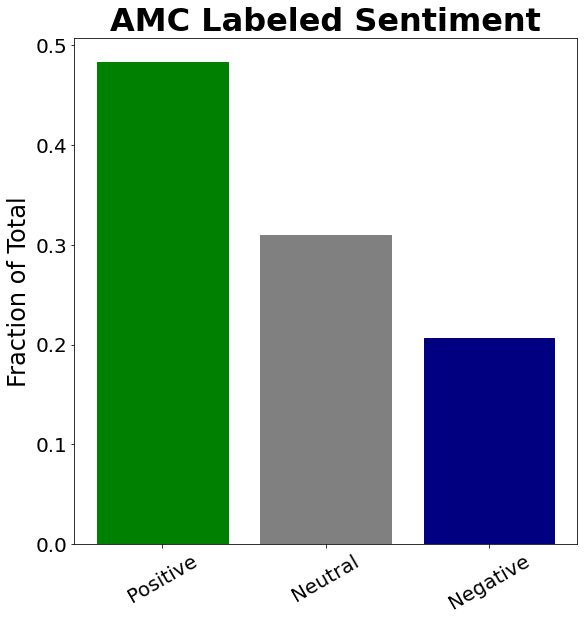

In [277]:
counts = labeled_amc['labels'].value_counts(normalize=True)
fig, ax = plt.subplots(figsize=(8, 8))
barlist = plt.bar(['Positive','Neutral','Negative'],counts)
barlist[0].set_color('green')
barlist[1].set_color('grey')
barlist[2].set_color('navy')
ax.set_ylabel('Fraction of Total', size=24)
plt.title("AMC Labeled Sentiment", fontsize=32, fontweight='bold')
plt.tight_layout()
plt.tick_params(labelsize=20)
plt.xticks(rotation=30)
plt.show()

In [255]:
unupgraded_lexicon = pd.read_csv('data/amc_numeric_sents.csv', low_memory=False)

In [256]:
def orig_assigner(sentiment):
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [257]:
unupgraded_lexicon['old_sentiment'] = unupgraded_lexicon['Compound Sentiment'].map(orig_assigner)
unupgraded_lexicon = unupgraded_lexicon[['cleaned_body','old_sentiment']]

In [260]:
labeled_amc = pd.concat([labeled_amc,unupgraded_lexicon],axis=1,join='inner')
labeled_amc = labeled_amc.loc[:,~labeled_amc.columns.duplicated()]
labeled_amc=labeled_amc[['created_utc','body','cleaned_body','new_sentiment','old_sentiment','labels']]

In [267]:
# labeled_amc.to_csv('data/labeled_amc.csv',index=False)

In [270]:
print(accuracy_score(labeled_amc['labels'],labeled_amc['new_sentiment']))
print(accuracy_score(labeled_amc['labels'],labeled_amc['old_sentiment']))

0.47
0.474


Both VADER models were about 47% accurate as compared to my manual labels in a random sample of 1000 comments. <br>
They can't account for context, sarcasm, etc.

## Modeling

Modeling AMC and GME comments with classification such as naive bayes, decision tree, random forest, and xgboost. Also implemented pipelines and cross validation for each model.

In [283]:
def eval_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    print(f'Training Accuracy: {model.score(X_train, y_train)}')
    y_pred = model.predict(X_test)
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
    plot_confusion_matrix(model, X_test, y_test)

## AMC sentiment prediction

In [374]:
# VADER predictions have been established as target.
X = labeled_amc['body']
y = labeled_amc['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [375]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

def comment_cleaner(comment):
    common_symbols = ['gt','amp','x200B','==&gt;','&gt','&amp;','#x200B;']
    punctuation = set(string.punctuation)
    to_keep = ['!','$','%','@']
    punctuation.difference_update(to_keep)
    comment = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', comment) #Remove URLs and links
    tokenizer = TweetTokenizer()
    comment = tokenizer.tokenize(comment)
    comment = [word for word in comment if word not in common_symbols] #Remove reoccuring symbol phrases
    comment = [word for word in comment if word not in punctuation] #Remove punctuation
    comment = pos_tag(comment)
    comment = [(word[0], get_wordnet_pos(word[1])) for word in comment]
    lemmatizer = WordNetLemmatizer() 
    comment = [lemmatizer.lemmatize(word[0], word[1]) for word in comment]
    return comment


### Naive Bayes

In [407]:
nb_pipe = Pipeline(steps=[('pre', CountVectorizer(tokenizer=comment_cleaner,max_features=200)),
                          ('tfidf', TfidfTransformer()),
                         ('nb', MultinomialNB())])
nb_cv = cross_validate(estimator=nb_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5)
nb_cv

{'fit_time': array([1.1945262 , 1.13302755, 1.12600327, 1.20697021, 1.22902322]),
 'score_time': array([0.29099703, 0.28697062, 0.29502606, 0.32300568, 0.35497117]),
 'test_score': array([0.53333333, 0.52666667, 0.5       , 0.51333333, 0.53333333])}

Training Accuracy: 0.6066666666666667
Test Accuracy: 0.552


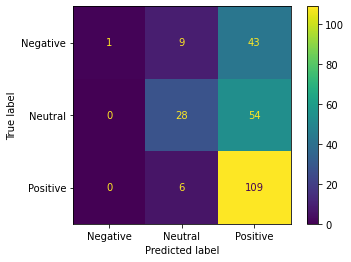

In [408]:
nb_pipe.fit(X_train, y_train)
eval_model(nb_pipe, X_train, X_test, y_train, y_test)

### Random Forest

In [386]:
rf_pipe = Pipeline(steps=[('pre', CountVectorizer(tokenizer=comment_cleaner, max_features=200)),
                         ('rf', RandomForestClassifier())])
rf_cv = cross_validate(estimator=rf_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5)
rf_cv

{'fit_time': array([1.86352825, 1.39597154, 1.37903023, 1.38300014, 1.40199995]),
 'score_time': array([0.29400301, 0.33599925, 0.31099582, 0.28799987, 0.30300021]),
 'test_score': array([0.54666667, 0.48666667, 0.48      , 0.5       , 0.52666667])}

Training Accuracy: 0.988
Test Accuracy: 0.512


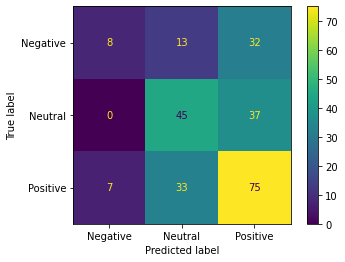

In [387]:
rf_pipe.fit(X_train, y_train)
eval_model(rf_pipe, X_train, X_test, y_train, y_test)

### Decision Tree

In [388]:
dt_pipe = Pipeline(steps=[('pre', CountVectorizer(tokenizer=comment_cleaner, max_features=200)),
                         ('dt', DecisionTreeClassifier())])
dt_cv = cross_validate(estimator=dt_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5)
dt_cv

{'fit_time': array([1.18097138, 1.227     , 1.18799949, 1.17501163, 1.15296865]),
 'score_time': array([0.28000188, 0.30402756, 0.29797029, 0.27601671, 0.29803157]),
 'test_score': array([0.38      , 0.43333333, 0.45333333, 0.45333333, 0.49333333])}

Training Accuracy: 0.988
Test Accuracy: 0.496


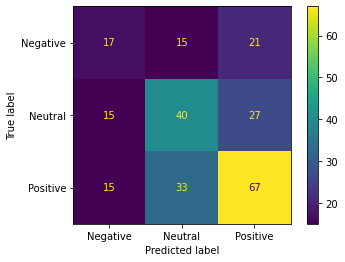

In [389]:
dt_pipe.fit(X_train, y_train)
eval_model(dt_pipe, X_train, X_test, y_train, y_test)

### XGBoost

In [391]:
xgb_pipe = Pipeline(steps=[('pre', CountVectorizer(tokenizer=comment_cleaner, max_features=200)),
                          ('xgb', XGBClassifier(eval_metric='mlogloss'))])
xgb_cv = cross_validate(estimator=xgb_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5)
xgb_cv

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboos

{'fit_time': array([1.40496802, 1.38599992, 1.36000037, 1.38799906, 1.36600113]),
 'score_time': array([0.30700183, 0.30600023, 0.31800199, 0.28700089, 0.47501588]),
 'test_score': array([0.54666667, 0.5       , 0.51333333, 0.54      , 0.55333333])}

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training Accuracy: 0.9693333333333334
Test Accuracy: 0.54


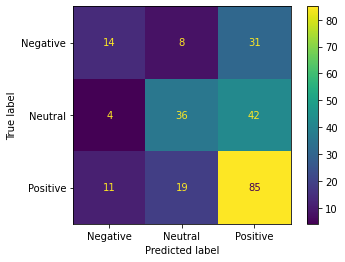

In [392]:
xgb_pipe.fit(X_train, y_train)
eval_model(xgb_pipe, X_train, X_test, y_train, y_test)

In [409]:
tuned_parameters = {
    'pre__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [1, 1e-1, 1e-2]
}

gridsearch = GridSearchCV(nb_pipe, tuned_parameters, scoring = 'accuracy', cv = 10)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'nb__alpha': 0.01,
 'pre__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__use_idf': False}

In [410]:
nb_pipe = Pipeline(steps=[('pre', CountVectorizer(tokenizer=comment_cleaner,max_features=200,ngram_range=(1,2))),
                          ('tfidf', TfidfTransformer(use_idf=False)),
                         ('nb', MultinomialNB())])
nb_cv = cross_validate(estimator=nb_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5)
nb_cv

{'fit_time': array([1.18368006, 1.18700004, 1.20000196, 1.27750659, 1.18222928]),
 'score_time': array([0.29197097, 0.30399942, 0.3070004 , 0.27913094, 0.33999896]),
 'test_score': array([0.52666667, 0.49333333, 0.51333333, 0.48      , 0.54      ])}

Training Accuracy: 0.5906666666666667
Test Accuracy: 0.532


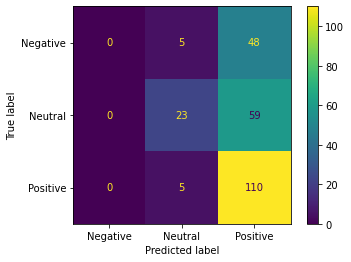

In [411]:
nb_pipe.fit(X_train, y_train)
eval_model(nb_pipe, X_train, X_test, y_train, y_test)

## Evaluation

All the models besides Naive Bayes were overfitting severely. I noticed when I was hand parsing the comments how difficult it was to classify them as a human so I don't blame the machine at all. I ran a grid search on the Naive Bayes model to try and optimize it, and then modeled it again with the suggested hyperparameters. So far, my best model has been the untuned Naive Bayes sitting at 55% test accuracy.

## Conclusion 

The model did well classifying the sentiment of comments based on VADER. The alternative to using VADER labeling as my target would be manual labeling of comments in a couple of 100k entry datasets. I ended up actually doing this for a 1000 comment random sample of AMC data. Given the evolving lingo as well as the sarcasm and context involved with each comment, there is no fool proof method including manual labeling. While I was reading the comments, I found myself between sentiments at times, often even considering all 3. The involvement of VADER in the bigger picture proves to be useful and reliable, however, I was able to beat it with my manually trained model. <br>
Through iterative modeling, I was able to test out Naive Bayes, decision tree, random forest, and XGBoost. Decision tree, random forest, and XGBoost had issues with overfitting which ruled them out for me. Naive Bayes did great and I optimized it with a gridsearch. <br>
The best use of this model is to predict the sentiment of AMC data. I will be deploying the model to a dashboard where users can do that. I would feel more comfortable applying this model to predict sentiments than I would with VADER or TextBlob, which I tried out in EDA but decided was inferior.
<br>
Given the context of the business problem, a financial product based on NLP designed with the stakeholder as well as the broader audience is in my opinion the best way at this time to profit from the information on wallstreetbets. This financial product is an ETF named RSAH (reddit sentiment analysis holdings). It holds the top 10 most mentioned tickers on WSB for the past 30d period. The  ETF will be rebalanced monthly with proprietary weighting.

## Future Research

Future work for this project includes manually labeling the GME comments and then training models based upon those labels. This would be tough work as well as tedious as many comments are quite subjective and interpretable in multiple ways.
<br>
Lastly, I would like to explore further in my time series work with NLP. I thought I was able to make good progress there. One thing I worked on was researching sentiment trends over time. I started working with stacked LSTMs to predict price as well. My intuition would be that the viable way to proceed would be to refine the sentiment analyzer before fusing it with several layers of quantitative financial data in some type of neural network.
<br>
Obviously over the course of several years, this may progress to development and implementation of low latency algorithmic trading strategies integrating machine readable indicators such as NLP.

## References

WSB scraping tutorial, great summary: https://algotrading101.com/learn/reddit-wallstreetbets-web-scraping/ <br>
VADER paper: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf <br>
NLP for trading: https://blog.quantinsti.com/natural-language-processing-trading/ <br>
Reddit API and Requests: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c <br>
PushShift API: https://medium.com/swlh/how-to-scrape-large-amounts-of-reddit-data-using-pushshift-1d33bde9286 <br>
Lexicon upgrade for context: https://github.com/asad70/reddit-sentiment-analysis <br>
Plotly graphs: https://plotly.com/python/time-series/ <br>
API for WSB data: https://www.quiverquant.com/wallstreetbets/ <br>
Time Series with VADER: https://blog.quantinsti.com/vader-sentiment/ <br>